# Trend Factor Analysis

This notebook walks through a trend factor analysis, for both time series and cross-sectional strategies, in digital assets.

We will construct various trend factors and compare their performance across a range of statistical tests and financial evaluation criteria.

Trend following is a ubiquitous factor investing strategy and remains one of the best ways to capture convexity in cryptoassets.

To conduct this analysis, we will use **FactorLab**, an open-source python package we have created specifically for alpha and risk factor analysis. 

To install **FactorLab**:
`pip install factorlab`

In [95]:
# uncomment to install factorlab
# pip install factorlab

In [96]:
import pandas as pd
import numpy as np

# from cryptodatapy.extract.datarequest import DataRequest
# from cryptodatapy.extract.getdata import GetData
# from cryptodatapy.transform.clean import CleanData

from factorlab.feature_engineering.transformations import Transform
from factorlab.feature_engineering.factors.trend import Trend
from factorlab.signal_generation.signal import Signal
from factorlab.strategy_analysis.feature_selection import FeatureSelection
from factorlab.signal_generation.time_series_analysis import rolling_window, expanding_window, TimeSeriesAnalysis as TSA
from factorlab.strategy_analysis.factor_models import FactorModel
from factorlab.strategy_backtesting.portfolio_optimization import PortfolioOptimization
from factorlab.strategy_analysis.portfolio_sort import PortfolioSort
from factorlab.strategy_backtesting.performance import Performance
from factorlab.data_viz.data_viz import plot_series, plot_bar, plot_table, plot_scatter

## Data 

To collect the necessary data for this analysis (perpetual futures, funding rates, spot prices, and aggregate spot prices), we use **CryptoDataPy**, an open source python library that makes it easy to build high quality data pipelines for the analysis of cryptoassets.

With it, we can pull data from various exchanges and data vendors with ease, clean and stich it to create the longest possible price and total return series.

To install **CryptoDataPy**:
`pip install cryptodatapy`

In [97]:
# uncomment to install cryptodatapy
# pip install cryptodatapy

### Collect Data

- Funding rates and perptual futures OHLC prices from **Binance** futures exchange (2019-present)
- OHLC spot prices from **Binance** spot exchange (2017-2019)
- OHLC spot prices from **Cryptocompare** (2010-2017)

### Tickers

#### Binance

In [98]:
# # get all Binance perp futures tickers
# data_req = DataRequest(source='ccxt')
# perp_tickers = GetData(data_req).get_meta(method='get_markets_info', exch='binanceusdm', as_list=True)

In [99]:
# # get Binance spot tickers
# data_req = DataRequest(source='ccxt')
# spot_tickers = GetData(data_req).get_meta(method='get_markets_info', exch='binance', as_list=True)

In [100]:
# # find intersecting tickers
# binance_tickers = [ticker for ticker in perp_tickers if ticker in spot_tickers]

In [101]:
# # number of tickers
# len(binance_tickers)

#### Cryptocompare 

In [102]:
### # get cryptocompare tickers
# data_req = DataRequest(source='cryptocompare')
# cc_tickers = GetData(data_req).get_meta(method='get_assets_info', as_list=True)

In [103]:
# # keep only USDT ticker
# bin_tickers = []
# for ticker in binance_tickers:
#     if '/' in ticker and ticker.split('/')[1] == 'USDT':
#         bin_tickers.append(ticker.split('/')[0])

In [104]:
# # usdt tickers
# usdt_tickers = [ticker.split('/')[0] for ticker in binance_tickers if '/'in ticker and ticker.split('/')[1] == 'USDT']

In [105]:
# # intersecting tickers
# tickers = [ticker for ticker in usdt_tickers if ticker in cc_tickers]

### OHLC Prices

#### Binance - Perpetual Futures

In [106]:
# # pull daily OHLC and funding rates for perp futures on Binance USDM exchange
# data_req = DataRequest(source='ccxt',
#                        tickers=tickers, 
#                        fields=['open', 'high', 'low', 'close', 'volume', 'funding_rate'], 
#                        mkt_type='perpetual_future', 
#                        freq='d')

In [107]:
# df1 = GetData(data_req).get_series()

In [108]:
# df1.head()

In [109]:
# pull csv perp futures prices
df1 = pd.read_csv('../src/factorlab/datasets/data/binance_perp_fut_prices.csv', 
                  index_col=['date', 'ticker'],
                  parse_dates=['date']
                 )

#### Binance - Spot Prices

In [110]:
# # pull OHLC from Binance
# data_req = DataRequest(source='ccxt',
#                        tickers=tickers, 
#                        fields=['open', 'high', 'low', 'close', 'volume'], 
#                        freq='d')

In [111]:
# df2 = GetData(data_req).get_series()

In [112]:
# df2.head()

In [113]:
# pull csv spot prices, binance
df2 = pd.read_csv('../src/factorlab/datasets/data/binance_spot_prices.csv', 
                  index_col=['date', 'ticker'],
                  parse_dates=['date']
                 )

## CryptoCompare - Historical Spot

In [114]:
# # pull close and funding rates for agg spot data from CryptoCompare
# data_req = DataRequest(source='cryptocompare',
#                        tickers=tickers, 
#                        fields=['open', 'high', 'low', 'close', 'volume'], 
#                        freq='d')

In [115]:
# df3 = GetData(data_req).get_series()

In [116]:
# df3.head()

In [117]:
# pull csv spot prices, cryptocompare
df3 = pd.read_csv('../src/factorlab/datasets/data/cc_spot_prices.csv', 
                  index_col=['date', 'ticker'],
                  parse_dates=['date']
                 )

###  Preprocess Data

#### Stich perp futures, spot and historical spot OHLC prices

In [118]:
# stich dfs to extend price time series
df = df1.combine_first(df2).combine_first(df3)
df = df[['open', 'high', 'low', 'close', 'volume', 'funding_rate']]
df.funding_rate = df.funding_rate.fillna(0)

#### Clean data

Now, that we have all of our raw data, we can clean our data using the *CleanData* class in **CryptoDataPy** and chaining the following methods:

- *Filter outliers* to remove outliers using interquantile range and a threshold.
- *Repair outliers* and missing values using the IQR expected value.
- *Filter average trading value* to reduce the trading universe to include only asset trading a minimum of daily dollar volume (1 mil USD).
- *Remove missing values gaps* to drop the values of any series where sequential missing values are above some threshodl value.

In [119]:
# drop tickers with nobs < ts_obs
obs = df.groupby(level=1).count().min(axis=1)
drop_tickers_list = obs[obs < 700].index.to_list()
df = df.drop(drop_tickers_list, level=1, axis=0)

# drop tickers with nobs < cs_obs
obs = df.groupby(level=0).count().min(axis=1)
idx_start = obs[obs > 3].index[0]
df = df.unstack()[df.unstack().index > idx_start].stack(future_stack=True)

In [120]:
# number of assets
len(list(df.index.droplevel(0).unique()))

195

## Target and Factor Construction

In [121]:
# create ohlc df
ohlc = df[['open', 'high', 'low', 'close']].copy()

### Create Targets
Create log return and forward return target variables.

In [122]:
# compute total returns
ret_df = Transform(df.close).returns()
ret_df = pd.concat([ret_df, df.funding_rate], axis=1).dropna()
ret_df['tr'] = ret_df.close.subtract(ret_df.funding_rate, axis=0)

In [123]:
# compute forward returns
fwd_spot_ret = Transform(df.close).returns(lags=1, forward=True).to_frame('fwd_ret_1')
fwd_spot_ret['fwd_ret_5'] = Transform(df.close).returns(lags=5, forward=True)
fwd_spot_ret['fwd_ret_7'] = Transform(df.close).returns(lags=7, forward=True)
fwd_spot_ret['fwd_ret_10'] = Transform(df.close).returns(lags=10, forward=True)
fwd_spot_ret['fwd_ret_14'] = Transform(df.close).returns(lags=14, forward=True)
fwd_spot_ret['fwd_ret_20'] = Transform(df.close).returns(lags=20, forward=True)
fwd_spot_ret['fwd_ret_30'] = Transform(df.close).returns(lags=30, forward=True)
fwd_spot_ret['fwd_ret_60'] = Transform(df.close).returns(lags=60, forward=True)
fwd_spot_ret['fwd_ret_90'] = Transform(df.close).returns(lags=90, forward=True)
fwd_spot_ret['fwd_ret_180'] = Transform(df.close).returns(lags=180, forward=True)
fwd_spot_ret['fwd_ret_365'] = Transform(df.close).returns(lags=365, forward=True)

In [124]:
# normalize fwd rets
fwd_ret_norm = Transform(fwd_spot_ret).normalize(window_type='expanding')

In [125]:
# compute fwd relative returns
fwd_rel_ret = fwd_spot_ret.copy()
for col in fwd_rel_ret.columns:
    fwd_rel_ret[col] = fwd_spot_ret[col] - fwd_spot_ret[col].groupby('date').mean()

In [126]:
# mkt returns
mkt_ret = ret_df.close.unstack().mean(axis=1).to_frame('mkt_ret')

### Compute Trend Factors

- We compute a dozen trend factors across varying lookback windows which to compare performance.

In [127]:
# trend factors
# breakout
trend_df = Trend(ohlc, vwap=True, log=True, lookback=5).breakout()
trend_df['breakout_10'] = Trend(ohlc, vwap=True, log=True, lookback=10).breakout()
trend_df['breakout_15'] = Trend(ohlc, vwap=True, log=True, lookback=15).breakout()
trend_df['breakout_30'] = Trend(ohlc, vwap=True, log=True, lookback=30).breakout()
trend_df['breakout_45'] = Trend(ohlc, vwap=True, log=True, lookback=45).breakout()
trend_df['breakout_90'] = Trend(ohlc, vwap=True, log=True, lookback=90).breakout()
trend_df['breakout_180'] = Trend(ohlc, vwap=True, log=True, lookback=180).breakout()
trend_df['breakout_365'] = Trend(ohlc, vwap=True, log=True, lookback=365).breakout()
# price mom
trend_df['price_mom_5'] = Trend(ohlc, vwap=True, log=True, lookback=5).price_mom()
trend_df['price_mom_10'] = Trend(ohlc, vwap=True, log=True, lookback=10).price_mom()
trend_df['price_mom_15'] = Trend(ohlc, vwap=True, log=True, lookback=15).price_mom()
trend_df['price_mom_30'] = Trend(ohlc, vwap=True, log=True, lookback=30).price_mom()
trend_df['price_mom_45'] = Trend(ohlc, vwap=True, log=True, lookback=45).price_mom()
trend_df['price_mom_90'] = Trend(ohlc, vwap=True, log=True, lookback=90).price_mom()
trend_df['price_mom_180'] = Trend(ohlc, vwap=True, log=True, lookback=180).price_mom()
trend_df['price_mom_365'] = Trend(ohlc, vwap=True, log=True, lookback=365).price_mom()
# moving window diff
trend_df['mw_diff_5'] = Trend(ohlc, vwap=True, log=True, lookback=5, sm_window_type='ewm').mw_diff()
trend_df['mw_diff_10'] = Trend(ohlc, vwap=True, log=True, lookback=10, sm_window_type='ewm').mw_diff()
trend_df['mw_diff_15'] = Trend(ohlc, vwap=True, log=True, lookback=15, sm_window_type='ewm').mw_diff()
trend_df['mw_diff_30'] = Trend(ohlc, vwap=True, log=True, lookback=30, sm_window_type='ewm').mw_diff()
trend_df['mw_diff_45'] = Trend(ohlc, vwap=True, log=True, lookback=45, sm_window_type='ewm').mw_diff()
trend_df['mw_diff_90'] = Trend(ohlc, vwap=True, log=True, lookback=90, sm_window_type='ewm').mw_diff()
trend_df['mw_diff_180'] = Trend(ohlc, vwap=True, log=True, lookback=180, sm_window_type='ewm').mw_diff()
trend_df['mw_diff_365'] = Trend(ohlc, vwap=True, log=True, lookback=365, sm_window_type='ewm').mw_diff()
# divergence
trend_df['divergence_5'] = Trend(ohlc, vwap=True, log=True, lookback=5, sm_window_type='ewm').divergence()
trend_df['divergence_10'] = Trend(ohlc, vwap=True, log=True, lookback=10, sm_window_type='ewm').divergence()
trend_df['divergence_15'] = Trend(ohlc, vwap=True, log=True, lookback=15, sm_window_type='ewm').divergence()
trend_df['divergence_30'] = Trend(ohlc, vwap=True, log=True, lookback=30, sm_window_type='ewm').divergence()
trend_df['divergence_45'] = Trend(ohlc, vwap=True, log=True, lookback=45, sm_window_type='ewm').divergence()
trend_df['divergence_90'] = Trend(ohlc, vwap=True, log=True, lookback=90, sm_window_type='ewm').divergence()
trend_df['divergence_180'] = Trend(ohlc, vwap=True, log=True, lookback=180, sm_window_type='ewm').divergence()
trend_df['divergence_365'] = Trend(ohlc, vwap=True, log=True, lookback=365, sm_window_type='ewm').divergence()
# exp weighted mov avg crossover
trend_df['ewma_xover_2'] = Trend(ohlc, vwap=True, log=True,).ewma_wxover(s_k=[2, 4, 8], l_k=[6, 12, 24], signal=True)
trend_df['ewma_xover_3'] = Trend(ohlc, vwap=True, log=True,).ewma_wxover(s_k=[3, 6, 12], l_k=[9, 18, 36], signal=True)
trend_df['ewma_xover_4'] = Trend(ohlc, vwap=True, log=True,).ewma_wxover(s_k=[4, 8, 16], l_k=[12, 24, 48], signal=True)
trend_df['ewma_xover_5'] = Trend(ohlc, vwap=True, log=True,).ewma_wxover(s_k=[5, 10, 20], l_k=[15, 30, 60], signal=True)
trend_df['ewma_xover_6'] = Trend(ohlc, vwap=True, log=True,).ewma_wxover(s_k=[6, 12, 24], l_k=[18, 36, 72], signal=True)
trend_df['ewma_xover_7'] = Trend(ohlc, vwap=True, log=True,).ewma_wxover(s_k=[7, 14, 28], l_k=[21, 42, 84], signal=True)
trend_df['ewma_xover_ahl'] = Trend(ohlc, vwap=True, log=True,).ewma_wxover(s_k=[8, 16, 32], l_k=[24, 48, 96], signal=True)
# rsi
trend_df['rsi_5'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=5).rsi()
trend_df['rsi_10'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=10).rsi()
trend_df['rsi_15'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=15).rsi()
trend_df['rsi_30'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=30).rsi()
trend_df['rsi_45'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=45).rsi()
trend_df['rsi_90'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=90).rsi()
trend_df['rsi_180'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=180).rsi()
trend_df['rsi_365'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=365).rsi()
# stochastic
trend_df['stoch_5'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=5).stochastic()
trend_df['stoch_10'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=10).stochastic()
trend_df['stoch_15'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=15).stochastic()
trend_df['stoch_30'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=30).stochastic()
trend_df['stoch_45'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=45).stochastic()
trend_df['stoch_90'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=90).stochastic()
trend_df['stoch_180'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=180).stochastic()
trend_df['stoch_365'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=365).stochastic()
# intensity
trend_df['intensity_5'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=5).intensity()
trend_df['intensity_10'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=10).intensity()
trend_df['intensity_15'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=15).intensity()
trend_df['intensity_30'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=30).intensity()
trend_df['intensity_45'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=45).intensity()
trend_df['intensity_90'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=90).intensity()
trend_df['intensity_180'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=180).intensity()
trend_df['intensity_365'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=365).intensity()
# time trend
trend_df['time_trend_5'] = Trend(ohlc, vwap=True, log=True, lookback=5).time_trend()
trend_df['time_trend_10'] = Trend(ohlc, vwap=True, log=True, lookback=10).time_trend()
trend_df['time_trend_15'] = Trend(ohlc, vwap=True, log=True, lookback=15).time_trend()
trend_df['time_trend_30'] = Trend(ohlc, vwap=True, log=True, lookback=30).time_trend()
trend_df['time_trend_45'] = Trend(ohlc, vwap=True, log=True, lookback=45).time_trend()
trend_df['time_trend_90'] = Trend(ohlc, vwap=True, log=True, lookback=90).time_trend()
trend_df['time_trend_180'] = Trend(ohlc, vwap=True, log=True, lookback=180).time_trend()
trend_df['time_trend_365'] = Trend(ohlc, vwap=True, log=True, lookback=365).time_trend()
# alpha mom
trend_df['alpha_mom_5'] = Trend(ohlc, vwap=True, log=True, lookback=5).alpha_mom()
trend_df['alpha_mom_10'] = Trend(ohlc, vwap=True, log=True, lookback=10).alpha_mom()
trend_df['alpha_mom_15'] = Trend(ohlc, vwap=True, log=True, lookback=15).alpha_mom()
trend_df['alpha_mom_30'] = Trend(ohlc, vwap=True, log=True, lookback=30).alpha_mom()
trend_df['alpha_mom_45'] = Trend(ohlc, vwap=True, log=True, lookback=45).alpha_mom()
trend_df['alpha_mom_90'] = Trend(ohlc, vwap=True, log=True, lookback=90).alpha_mom()
trend_df['alpha_mom_180'] = Trend(ohlc, vwap=True, log=True, lookback=180).alpha_mom()
trend_df['alpha_mom_365'] = Trend(ohlc, vwap=True, log=True, lookback=365).alpha_mom()
# energy
trend_df['energy_5'] = Trend(ohlc, vwap=True, log=True, lookback=5).energy()
trend_df['energy_10'] = Trend(ohlc, vwap=True, log=True, lookback=10).energy()
trend_df['energy_15'] = Trend(ohlc, vwap=True, log=True, lookback=15).energy()
trend_df['energy_30'] = Trend(ohlc, vwap=True, log=True, lookback=30).energy()
trend_df['energy_45'] = Trend(ohlc, vwap=True, log=True, lookback=45).energy()
trend_df['energy_90'] = Trend(ohlc, vwap=True, log=True, lookback=90).energy()
trend_df['energy_180'] = Trend(ohlc, vwap=True, log=True, lookback=180).energy()
trend_df['energy_365'] = Trend(ohlc, vwap=True, log=True, lookback=365).energy()

/Users/nickl/opt/anaconda3/envs/factorlab/lib/python3.9/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/Users/nickl/opt/anaconda3/envs/factorlab/lib/python3.9/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/Users/nickl/opt/anaconda3/envs/factorlab/lib/python3.9/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/Users/nickl/opt/anaconda3/envs/factorlab/lib/python3.9/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/Users/nickl/opt/anaconda3/envs/factorlab/lib/python3.9/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero 

In [128]:
# normalize trend factors
trend_z_df = Transform(trend_df).normalize(window_type='expanding')

In [129]:
trend_z_df.head()

breakout_5  breakout_10  breakout_15  breakout_30  \
date       ticker                                                      
2014-02-04 1INCH          NaN          NaN          NaN          NaN   
           AAVE           NaN          NaN          NaN          NaN   
           ACH            NaN          NaN          NaN          NaN   
           ADA            NaN          NaN          NaN          NaN   
           AGLD           NaN          NaN          NaN          NaN   

                   breakout_45  breakout_90  breakout_180  breakout_365  \
date       ticker                                                         
2014-02-04 1INCH           NaN          NaN           NaN           NaN   
           AAVE            NaN          NaN           NaN           NaN   
           ACH             NaN          NaN           NaN           NaN   
           ADA             NaN          NaN           NaN           NaN   
           AGLD            NaN          NaN           NaN           NaN   

                   price_mom_5  price_mom_10  ...  alpha_mom_180  \
date       ticker                             ...                  
2014-02-04 1INCH           NaN           NaN  ...            NaN   
           AAVE            NaN           NaN  ...            NaN   
           ACH             NaN           NaN  ...            NaN   
           ADA             NaN           NaN  ...            NaN   
           AGLD            NaN           NaN  ...            NaN   

                   alpha_mom_365  energy_5  energy_10  energy_15  energy_30  \
date       ticker                                                             
2014-02-04 1INCH             NaN       NaN        NaN        NaN        NaN   
           AAVE              NaN       NaN        NaN        NaN        NaN   
           ACH               NaN       NaN        NaN        NaN        NaN   
           ADA               NaN       NaN        NaN        NaN        NaN   
           AGLD              NaN       NaN        NaN        NaN        NaN   

                   energy_45  energy_90  energy_180  energy_365  
date       ticker                                                
2014-02-04 1INCH         NaN        NaN         NaN         NaN  
           AAVE          NaN        NaN         NaN         NaN  
           ACH           NaN        NaN         NaN         NaN  
           ADA           NaN        NaN         NaN         NaN  
           AGLD          NaN        NaN         NaN         NaN  

[5 rows x 87 columns]

# Signal Analysis

Generate time series and cross-sectional trend signals using ```Signal``` class and the ```compute_signals``` method. Signals convert raw factor values to signals. The ***signal_type*** argument can be set to either a continuous signal (*signal*) with values between -1 and 1 (default), a discrete signal (*disc_signal*) with avalue -1, 0, 1, signal quantiles (*signal_quantiles*) with discrete values between -1 and 1 (e.g. -1, -0.5, 0 , 0.5, 1 for *signal_quantiles* with factor_bins=5) and signal rank (*signal_rank*) with values of -1, 0 and 1 for  long/short cross-sectional strategies with the top/bottom n_factors).

In [130]:
signals_ts_df = Signal(ret_df.tr, trend_df, strategy='ts_ls').compute_signals()

In [131]:
signals_cs_df = Signal(ret_df.tr, trend_df, strategy='ts_cs').compute_signals()

## Visualize Signals

In [132]:
ts_signals_vs_ret = pd.concat([signals_ts_df.price_mom_30, fwd_spot_ret.fwd_ret_7], axis=1).dropna()

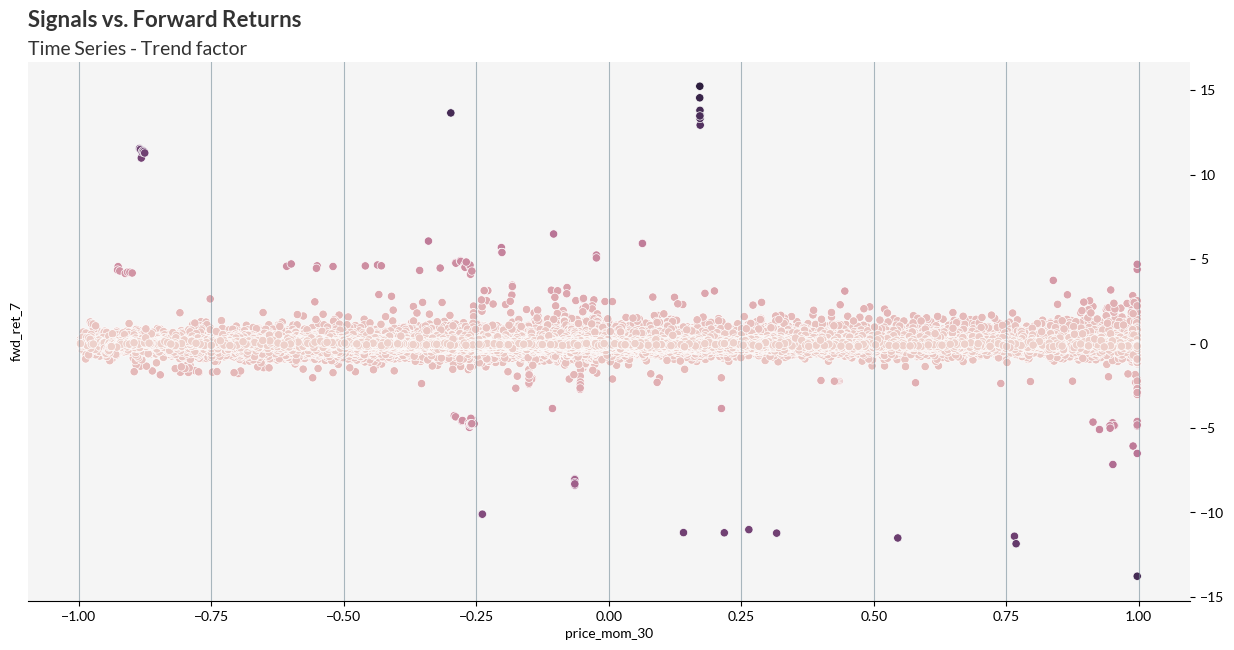

In [133]:
plot_scatter(ts_signals_vs_ret, x='price_mom_30', y='fwd_ret_7', hue=ts_signals_vs_ret.fwd_ret_7.abs(), title='Signals vs. Forward Returns', subtitle='Time Series - Trend factor')

In [134]:
cs_signals_vs_ret = pd.concat([signals_cs_df.price_mom_30, fwd_spot_ret.fwd_ret_7], axis=1).dropna()

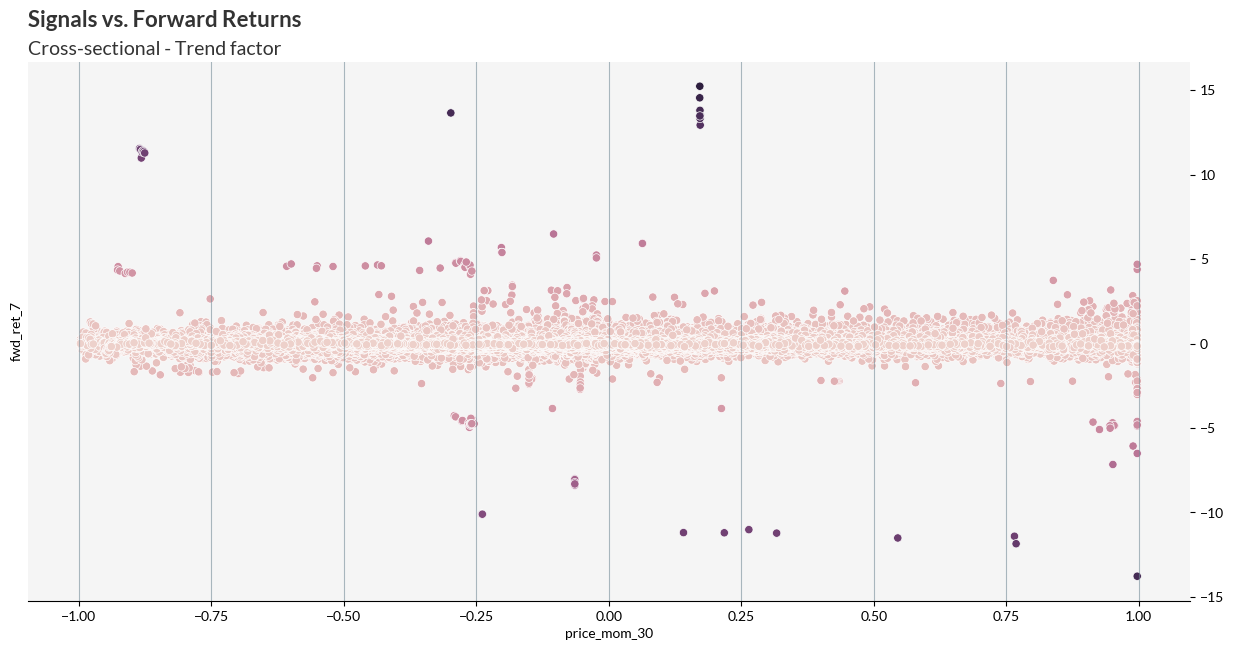

In [135]:
plot_scatter(ts_signals_vs_ret, x='price_mom_30', y='fwd_ret_7', hue=ts_signals_vs_ret.fwd_ret_7.abs(), title='Signals vs. Forward Returns', subtitle='Cross-sectional - Trend factor')

## Statistical Tests

Statistical tests allow us to assess the strenght of the relationship between the alpha factors (features) and foward returns (target variable).


### Filter Methods: 
Correlation measures, e.g. spearman rank correlation (aka information coefficient), and association measures, e.g. mutul information, allow us to evaluate the predictive relationship between an alpha factors and forward returns. 
- The `strategy` parameter in the `filter` method can be set to either "ts" or "cs" for either time series or cross-sectional strategies.

In [136]:
FeatureSelection(fwd_ret_norm.fwd_ret_7, signals_ts_df, strategy='ts', feature_bins=5, target_bins=3, window_type='fixed').filter(method='cramer_v')

,cramer_v
rsi_365,0.09
mw_diff_30,0.08
mw_diff_45,0.08
mw_diff_90,0.08
time_trend_90,0.08
...,...
energy_5,0.03
intensity_10,0.03
divergence_5,0.03
stoch_5,0.03


In [137]:
FeatureSelection(fwd_ret_norm.fwd_ret_7, signals_cs_df, strategy='cs', feature_bins=5, target_bins=3, window_type='fixed').filter(method='cramer_v')

,cramer_v
rsi_45,0.08
rsi_30,0.08
mw_diff_10,0.08
mw_diff_15,0.08
rsi_90,0.08
...,...
divergence_5,0.03
divergence_30,0.03
intensity_90,0.03
divergence_45,0.03


### Information Coefficient (IC):
The information coefficient (or spearman rank correlation) can be computed over a rolling window to allow us to see the change in predictive relationship between the factors and forward returns.


In [138]:
# IC rolling window for time series strategy
ic_ts_df = FeatureSelection(fwd_ret_norm.fwd_ret_7, signals_ts_df, strategy='ts', feature_bins=5, target_bins=3, window_size=365).ic(feature='price_mom_30')

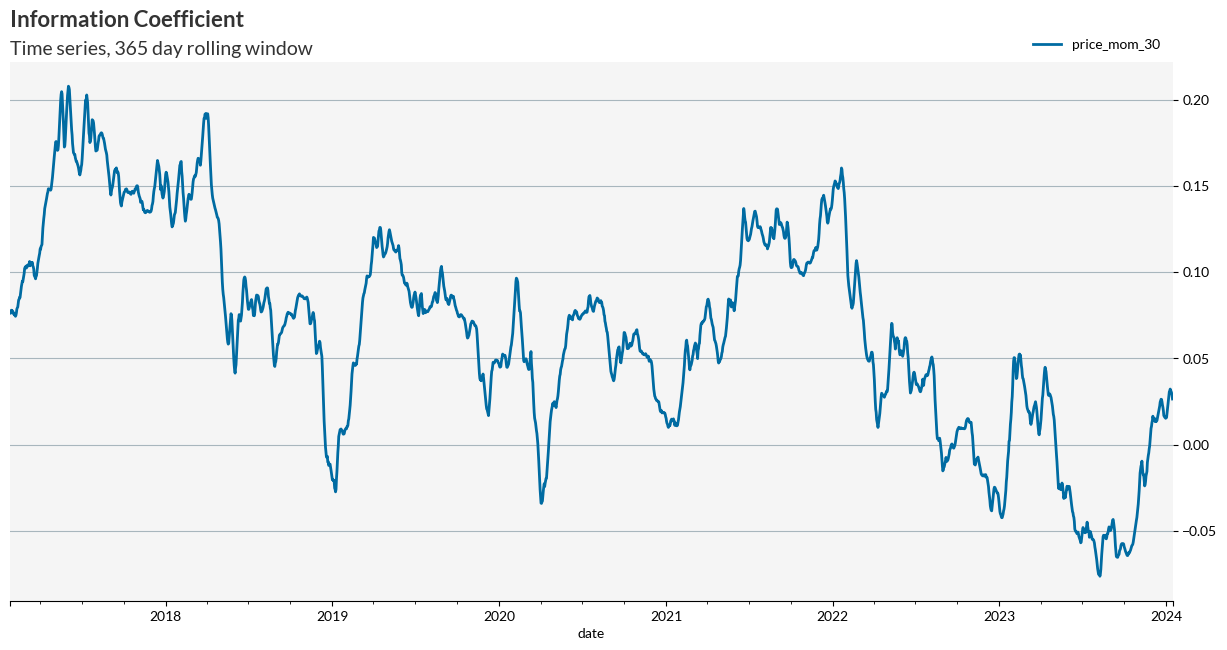

In [139]:
plot_series(ic_ts_df.dropna(), 
            title='Information Coefficient',
            subtitle='Time series, 365 day rolling window'
           )

In [140]:
# IC rolling window for cross sectional strategy
ic_cs_df = FeatureSelection(fwd_ret_norm.fwd_ret_7, signals_cs_df, strategy='cs', feature_bins=5, target_bins=3, window_size=365).ic(feature='price_mom_30')

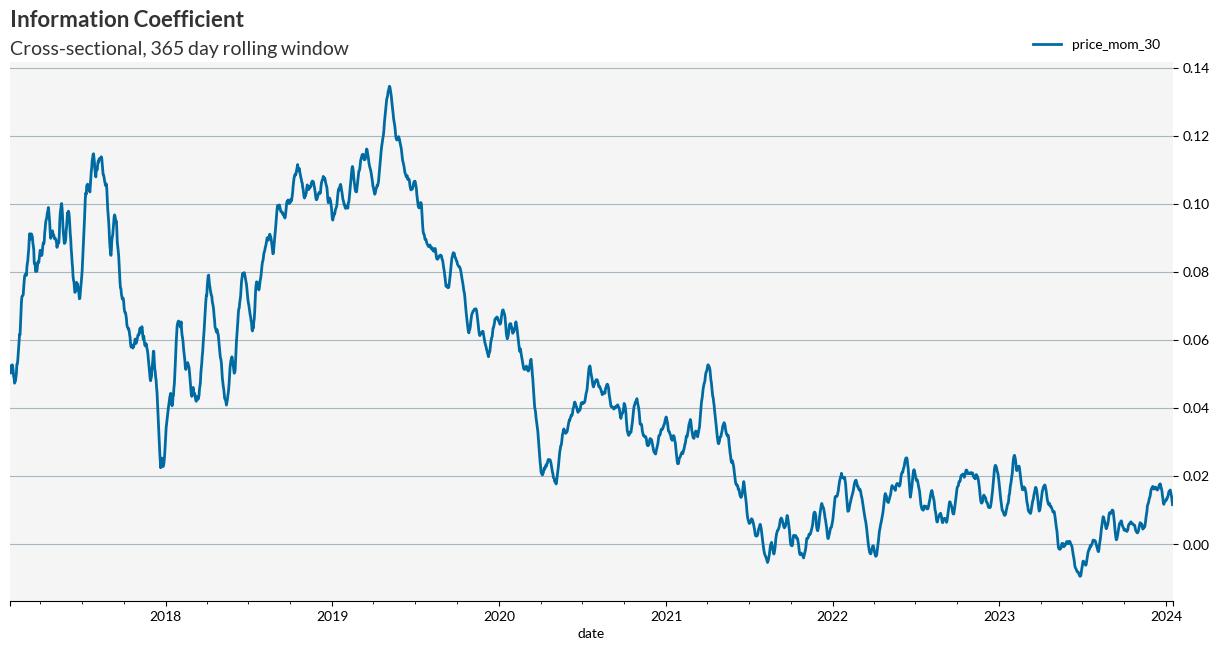

In [141]:
plot_series(ic_cs_df.dropna(), 
            title='Information Coefficient',
            subtitle='Cross-sectional, 365 day rolling window'
           )

### Factor Models
We can assess the statistical and economic significance of factors by regression them on forward returns (normalized.

This can be done in the time series (pooled regression) or the cross-section (fama-macbeth).


In [142]:
# pooled regression for time series 
FactorModel(fwd_ret_norm.fwd_ret_7, signals_ts_df, strategy='ts').pooled_regression(multivariate=False)

,beta,std_error,p-val,f_p-val,R-squared
price_mom_30,0.187715,0.006341,0.0,0.0,0.007961
energy_30,0.226388,0.009224,0.0,0.0,0.006724
stoch_30,0.101587,0.002985,0.0,0.0,0.006582
time_trend_30,0.134749,0.004725,0.0,0.0,0.005992
mw_diff_30,0.130037,0.004743,0.0,0.0,0.005921
...,...,...,...,...,...
alpha_mom_5,-0.015182,0.006222,0.014682,0.014683,0.000043
alpha_mom_30,0.008109,0.005236,0.121467,0.121468,0.000017
alpha_mom_10,-0.007334,0.005605,0.190762,0.190763,0.000012
alpha_mom_90,0.003852,0.004225,0.361881,0.361882,0.000005


In [143]:
# cross sectional fama-macbeth
FactorModel(fwd_ret_norm.fwd_ret_7, signals_cs_df, strategy='cs').fama_macbeth_regression(multivariate=False)

,beta,std_error,t-stat
mw_diff_30,0.201215,0.015626,12.877032
mw_diff_15,0.207250,0.016444,12.603605
price_mom_15,0.240243,0.019360,12.409316
time_trend_30,0.197656,0.016016,12.341486
stoch_30,0.140033,0.012163,11.512865
...,...,...,...
energy_180,0.062849,0.015199,4.135100
breakout_180,0.051164,0.012535,4.081712
price_mom_180,0.056629,0.014088,4.019796
time_trend_180,0.022899,0.012455,1.838507


## Factor Returns
Factor returns (net of t-cost estimate) provide a measure of factor performance. 
- The `strategy` parameter in the factor returns function allows you to explore factor returns for both long-only '_l' and long/short strategies '_ls', for either time series 'ts' or cross-sectional 'cs' implementations. 
- The `tails` parameter allows you to keep only factor values in the tails of the distribution and ignore the rest. Often, the most predictive information is contained in the tails.

### Time Series

In [144]:
# ts trend returns
trend_ts_ret = Signal(ret_df.tr, trend_df, strategy='ts_ls', factor_bins=3).compute_signal_returns()

In [145]:
# ts trend portfolio returns
trend_ts_port_ret = PortfolioOptimization(trend_ts_ret, method='equal_weight', t_cost=None, rebal_freq=None).compute_portfolio_returns()

In [146]:
# ts trend portfolio performance
trend_ts_port_perf_table = Performance(trend_ts_port_ret, mkt_ret=mkt_ret, ret_type='log').table(metrics='all', rank_on='Sharpe ratio')

In [147]:
trend_ts_port_perf_table

,Cumulative return,Annual return,Annual volatility,Skewness,Kurtosis,Max drawdown,VaR,Tail ratio,Sharpe ratio,Sortino ratio,Calmar ratio,Omega ratio,Stability,Annual alpha,Alpha p-val,Beta,Beta p-val
stoch_45,158.81,0.76,0.65,-1.07,81.71,-0.56,-0.04,1.07,0.87,0.98,1.35,1.19,0.88,0.75,0.01,0.02,0.01
time_trend_30,47.05,0.54,0.54,-1.18,104.77,-0.50,-0.03,1.20,0.80,0.89,1.09,1.19,0.79,0.54,0.02,0.01,0.43
stoch_30,95.35,0.66,0.64,-0.91,83.45,-0.63,-0.04,1.13,0.80,0.90,1.06,1.18,0.90,0.67,0.02,-0.00,0.68
time_trend_45,41.30,0.52,0.53,-0.89,107.75,-0.49,-0.03,1.18,0.78,0.89,1.05,1.18,0.83,0.51,0.02,0.02,0.00
intensity_45,23.99,0.43,0.46,1.10,76.54,-0.55,-0.03,1.15,0.78,0.97,0.79,1.16,0.77,0.41,0.02,0.05,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
alpha_mom_10,-0.84,-0.18,0.44,5.20,224.01,-0.96,-0.02,0.79,-0.46,-0.56,-0.19,0.87,0.88,-0.18,0.18,-0.01,0.09
energy_5,-0.79,-0.16,0.33,-18.43,604.02,-0.85,-0.01,0.90,-0.52,-0.44,-0.19,0.83,0.18,-0.15,0.14,-0.04,0.00
energy_10,-0.83,-0.18,0.35,-16.25,503.99,-0.87,-0.01,1.06,-0.58,-0.49,-0.21,0.84,0.23,-0.17,0.10,-0.04,0.00
alpha_mom_45,-0.92,-0.24,0.40,-5.91,139.43,-0.93,-0.02,0.90,-0.69,-0.66,-0.26,0.84,0.86,-0.24,0.04,0.01,0.14


In [148]:
# ts trend cum returns 
trend_ts_cum_ret = Performance(trend_ts_port_ret, mkt_ret=mkt_ret, ret_type='log', window_type='expanding').cum_ret()

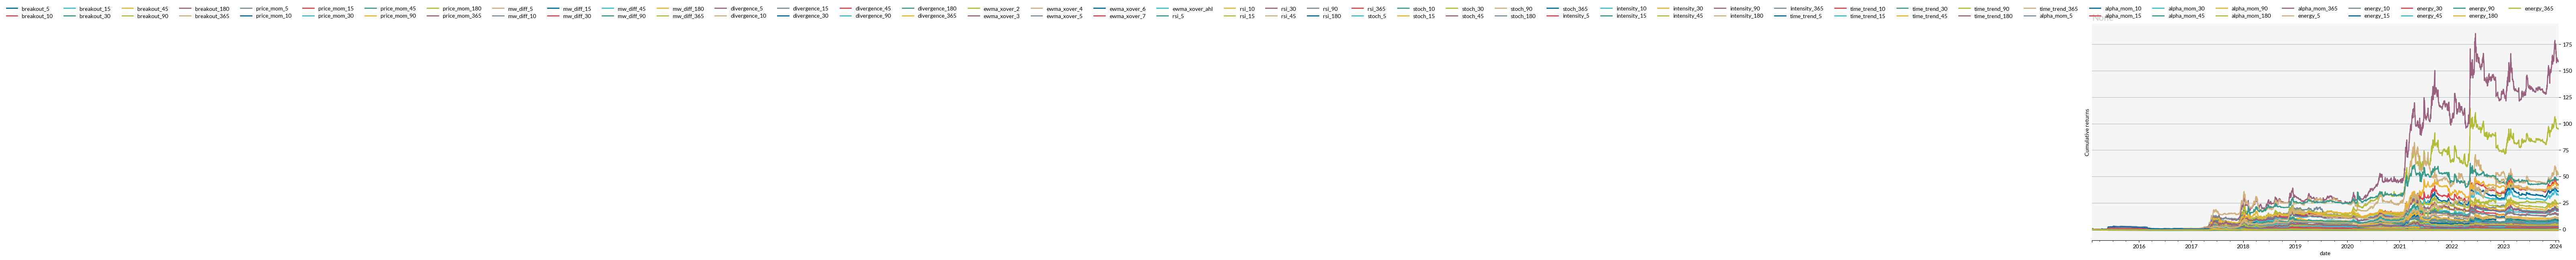

In [149]:
plot_series(trend_ts_cum_ret, y_label='Cumulative returns')

In [150]:
trend_ts_port_perf_table.mean()

Cumulative return      9.902989
Annual return          0.143333
Annual volatility      0.539770
Skewness              -2.192184
Kurtosis             120.479195
Max drawdown          -0.770805
VaR                   -0.032184
Tail ratio             1.057701
Sharpe ratio           0.182989
Sortino ratio          0.223563
Calmar ratio           0.248276
Omega ratio            1.035632
Stability              0.614943
Annual alpha           0.135632
Alpha p-val            0.407126
Beta                   0.018276
Beta p-val             0.063103
dtype: float64

### Cross-Sectional
Cross-sectional strategies sorts assets in the cross-section into equal-weighted portfolios based on their factor values. Weights for each portfolio can be scaled by on the portfolios quantile (e.g. 1 for the assets in the top quintile of factor values, 0.5 for the 2nd quintile, 0 for the third, etc), or traditional portfolio sorts where top vs. bottom quantiles are given weights of 1 and -1.

In [151]:
# cs trend returns
trend_cs_ret = Signal(ret_df.tr, trend_df, strategy='cs_ls', factor_bins=3).compute_signal_returns()

In [152]:
# cs trend portfolio returns
trend_cs_port_ret = PortfolioOptimization(trend_cs_ret, method='equal_weight', t_cost=None, rebal_freq=None).compute_portfolio_returns()

In [153]:
# cs trend portfolio performance
trend_cs_port_perf_table = Performance(trend_cs_port_ret, mkt_ret=mkt_ret, ret_type='log').table(metrics='all', rank_on='Sharpe ratio')

In [154]:
trend_cs_port_perf_table

,Cumulative return,Annual return,Annual volatility,Skewness,Kurtosis,Max drawdown,VaR,Tail ratio,Sharpe ratio,Sortino ratio,Calmar ratio,Omega ratio,Stability,Annual alpha,Alpha p-val,Beta,Beta p-val
ewma_xover_ahl,1.51,0.11,0.38,0.43,238.54,-0.55,-0.02,1.15,0.27,0.30,0.20,1.07,0.23,0.09,0.48,0.05,0.00
ewma_xover_7,1.41,0.10,0.37,1.30,232.23,-0.55,-0.02,1.12,0.26,0.30,0.19,1.07,0.20,0.09,0.49,0.05,0.00
stoch_90,1.30,0.10,0.40,-0.43,367.72,-0.58,-0.02,1.11,0.23,0.25,0.17,1.07,0.32,0.09,0.53,0.03,0.00
ewma_xover_6,1.16,0.09,0.38,1.09,231.75,-0.54,-0.02,1.10,0.23,0.25,0.17,1.06,0.17,0.08,0.56,0.05,0.00
ewma_xover_5,0.89,0.07,0.39,0.60,238.60,-0.52,-0.02,1.05,0.18,0.20,0.14,1.05,0.16,0.06,0.65,0.04,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
price_mom_5,-1.00,-0.45,0.46,-5.53,242.16,-1.00,-0.02,0.73,-1.30,-1.25,-0.45,0.67,0.83,-0.45,0.00,0.00,0.80
price_mom_180,-0.98,-0.35,0.33,-15.23,454.24,-0.98,-0.01,0.85,-1.33,-1.15,-0.36,0.68,0.84,-0.35,0.00,-0.04,0.00
energy_10,-0.99,-0.44,0.44,-7.45,279.33,-1.00,-0.02,0.75,-1.34,-1.24,-0.45,0.65,0.84,-0.44,0.00,0.00,0.87
mw_diff_5,-1.00,-0.48,0.46,-5.23,256.43,-1.00,-0.02,0.71,-1.41,-1.37,-0.48,0.64,0.85,-0.48,0.00,0.01,0.06


In [155]:
# ts trend cum returns
trend_cs_cum_ret = Performance(trend_cs_port_ret.loc['2017-01-01':], mkt_ret=mkt_ret, ret_type='log', window_type='expanding').cum_ret()

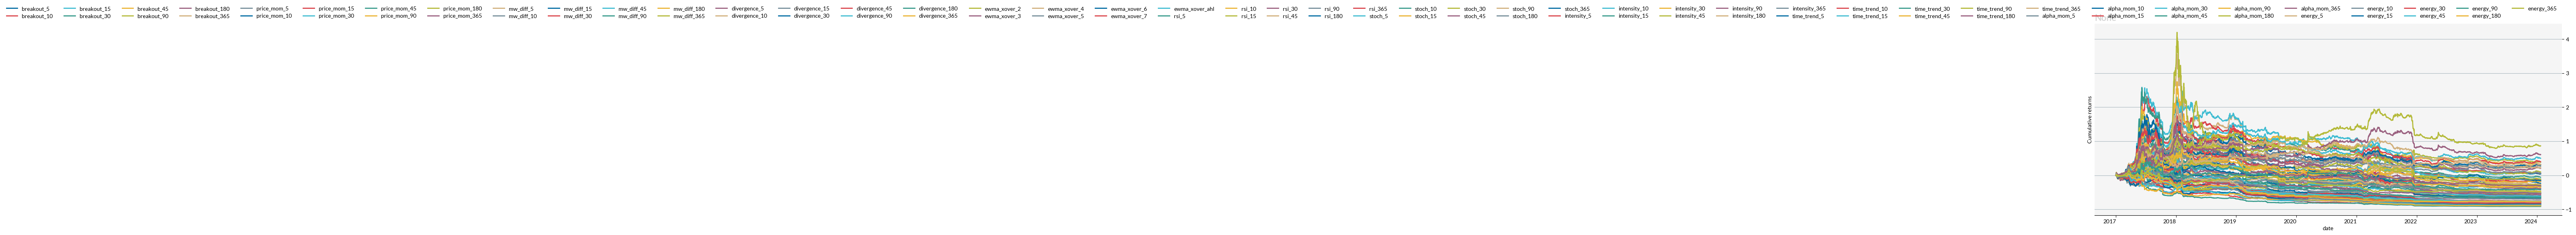

In [156]:
plot_series(trend_cs_cum_ret.dropna(), y_label='Cumulative returns')

In [157]:
trend_cs_port_perf_table.mean()

Cumulative return     -0.537471
Annual return         -0.182644
Annual volatility      0.400805
Skewness              -2.818276
Kurtosis             257.617931
Max drawdown          -0.828621
VaR                   -0.018966
Tail ratio             0.920460
Sharpe ratio          -0.533793
Sortino ratio         -0.528276
Calmar ratio          -0.187241
Omega ratio            0.864368
Stability              0.581494
Annual alpha          -0.187701
Alpha p-val            0.286322
Beta                   0.019540
Beta p-val             0.141264
dtype: float64

### Dual Strategies
Dual strategies (e.g. dual momentum) go long/short assets with factors that are high/low in both the cross section (relative to other assets) and in the time series (relative to the asset's own history). Dual strategies can enhance risk-adjusted returns by combining both time series and cross sectional strategies.

In [158]:
# dual trend returns
# trend_dual_ret = Factor(trend_df.loc['2016-01-01':], ret_df.tr, strategy='dual_ls', factor_bins=3).returns(signal_type='signal_quantiles', rebal_freq=7, t_cost=0.0025, weighting='ew')

In [159]:
# trend_dual_perf_table = Performance(trend_dual_ret, mkt_ret=mkt_ret, ret_type='log').table(metrics='all', rank_on='Sharpe ratio')

In [160]:
# trend_dual_perf_table

In [161]:
# Performance(trend_dual_ret, mkt_ret=mkt_ret, ret_type='log', window_type='expanding').plot_metric()

In [162]:
# trend_dual_perf_table.mean()

## Portfolio Sorts
Sorting portfolios into quantile returns provide a measure of alpha factor performance. 

We can use the ```quantiles``` method to analyze returns across bins/quantiles in order to assess the robustness of the alpha factor. Returns which increase monotonically with quantiles are likely to be more reliable that those with positive but non-monotonic relationships.

- The `factor` parameter in the quantile method allows us to select the factor for which to create quantiles. 
- The `metric` parameter allows us to compute a specific metrics from the ```Performance``` class. Here we use the default 'ret' value for returns.
- The ```rebal_freq``` parameter allows us to modify the rebalancing frequency for the strategy. This value defaults to 1, meaning changing with each period/frequency. We select '7' for weekly rebalancing with daily data frequency.

### Time Series Strategy

In [163]:
trend_ts_quantile_port = PortfolioSort(ret_df.tr, 
                   trend_df[[trend_ts_port_perf_table.iloc[0].name]], 
                   factor_bins={trend_ts_port_perf_table.iloc[0].name: ('ts', 3)},
                   fill_na=True
                  ).compute_quantile_portfolios()

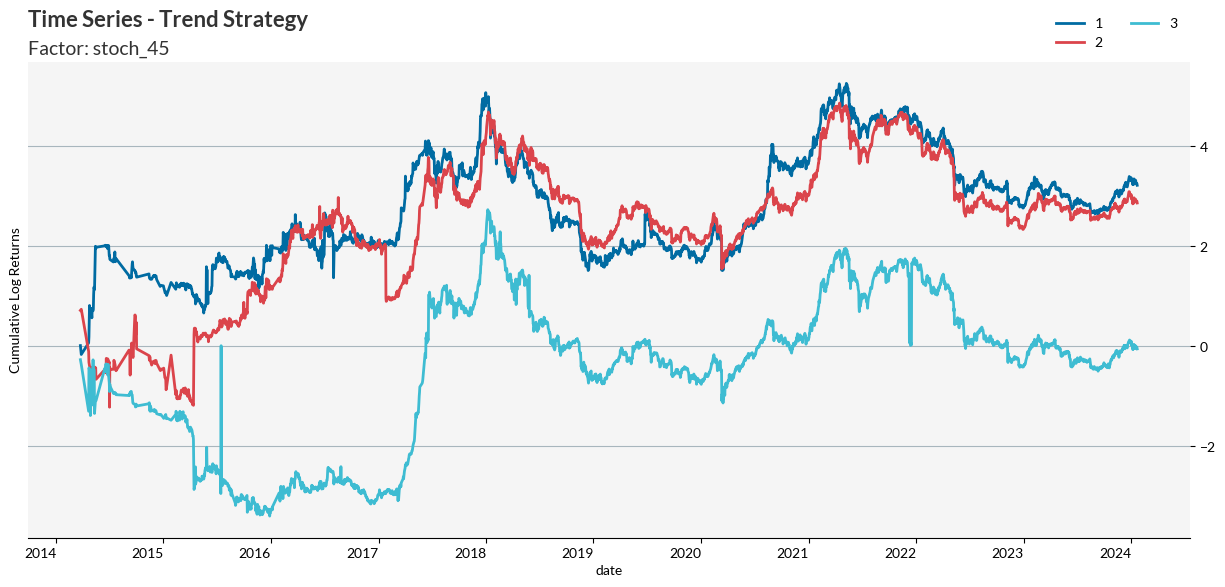

In [164]:
plot_series(trend_ts_quantile_port[trend_ts_port_perf_table.iloc[0].name].unstack().cumsum(),             
            title="Time Series - Trend Strategy",
            subtitle=f"Factor: {trend_ts_port_perf_table.iloc[0].name}",
            y_label='Cumulative Log Returns')

In [165]:
trend_ts_quantile_perf = PortfolioSort(ret_df.tr, 
                   trend_df[[trend_ts_port_perf_table.iloc[0].name]], 
                   factor_bins={trend_ts_port_perf_table.iloc[0].name: ('ts', 3)},
                   fill_na=True
                  ).performance(metric='ann_ret')

In [166]:
trend_ts_quantile_perf

,stoch_45
1,0.3867
2,0.3377
3,-0.0053


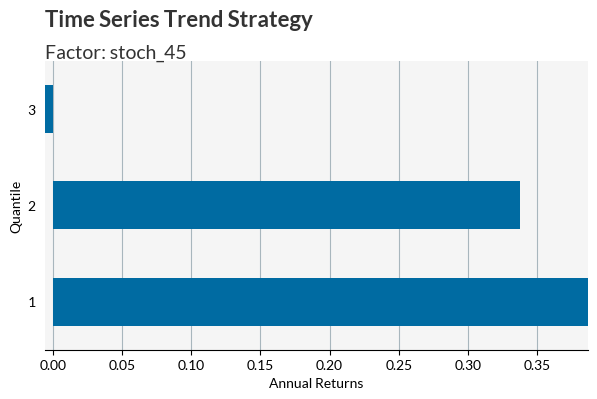

In [167]:
plot_bar(trend_ts_quantile_perf,
         axis='horizontal',
         title="Time Series Trend Strategy",
         subtitle=f"Factor: {trend_ts_port_perf_table.iloc[0].name}",
         y_label='Quantile',
         x_label='Annual Returns'
        )

### Cross-sectional Strategy

In [168]:
trend_cs_quantile_port = PortfolioSort(ret_df.tr, 
                   trend_df[[trend_cs_port_perf_table.iloc[0].name]], 
                   factor_bins={trend_cs_port_perf_table.iloc[0].name: ('cs', 5)},
                   fill_na=True
                  ).compute_quantile_portfolios()

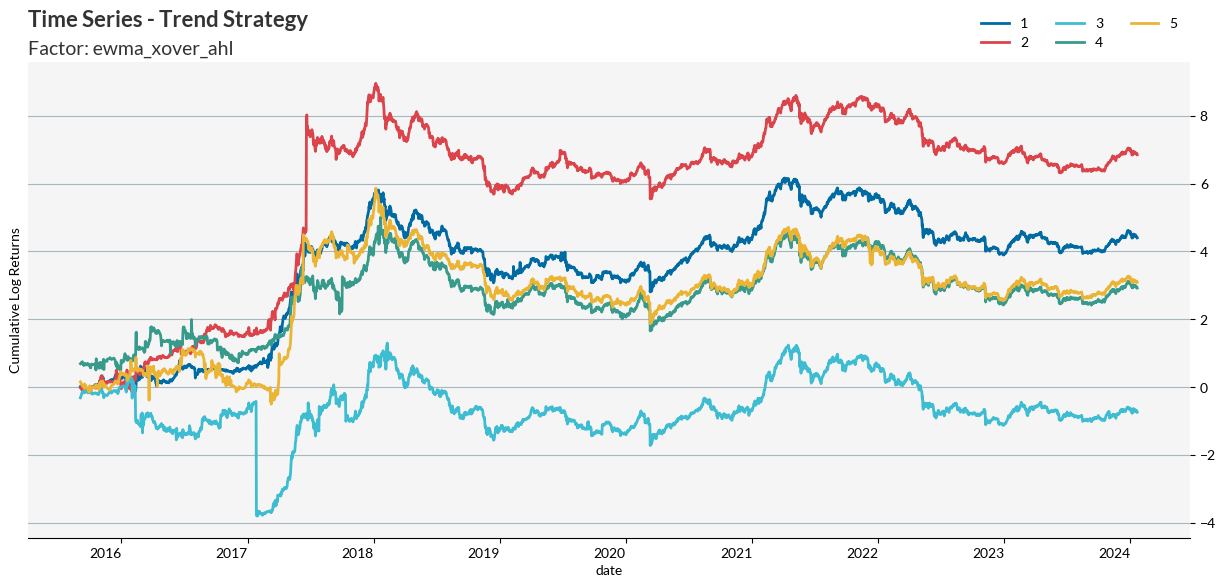

In [169]:
plot_series(trend_cs_quantile_port[trend_cs_port_perf_table.iloc[0].name].unstack().cumsum(),             
            title="Time Series - Trend Strategy",
            subtitle=f"Factor: {trend_cs_port_perf_table.iloc[0].name}",
            y_label='Cumulative Log Returns')

In [170]:
trend_cs_quantile_perf = PortfolioSort(ret_df.tr, 
                   trend_df[[trend_cs_port_perf_table.iloc[0].name]], 
                   factor_bins={trend_cs_port_perf_table.iloc[0].name: ('cs', 5)},
                   fill_na=True
                  ).performance(metric='ann_ret')

In [171]:
trend_cs_quantile_perf

,ewma_xover_ahl
1,0.6327
2,1.1451
3,-0.0784
4,0.3849
5,0.4110


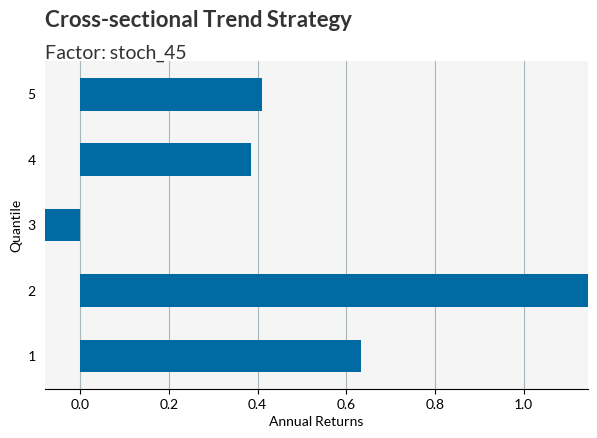

In [172]:
plot_bar(trend_cs_quantile_perf,
         axis='horizontal',
         title="Cross-sectional Trend Strategy",
         subtitle=f"Factor: {trend_ts_port_perf_table.iloc[0].name}",
         y_label='Quantile',
         x_label='Annual Returns'
        )

## Factor Robustness

A robust factor should produce positive returns regardless of changes in construction methodology, inputs and parameter values. One way of assessing the robustness of a factor is to examine how returns change across various implementations, inputs, parameters and sample periods. This can be done as part with the ```factor_param_grid_search``` function:
- The ```feat_args``` parameters allows us to vary all of the attributes that are used to compute all factors with the ```Trend``` class.
- The ```algo_args``` parameters allow us to vary all of the arguments used by the methods which compute specific trend algorithms, e.g. ```price_mom``` or ```time_trend```.

### Factor Parameter Grid Search

The ```Factor``` class has a ```return``` method which computes factor returns. The class attributes and method arguments can be optimized to achieve better performance. We can use the ```strategy_param_grid_search``` to assess the factor strategy's sensitivity to these inputs.

#### Time Series
We explore the parameter space for the best performing time series trend strategy.

In [173]:
# metrics_df = factor_param_grid_search(df, ret_df.tr, Trend, 'stochastic', metric='sharpe_ratio',
#                                              feat_args={
#                                                  'sm_window_type': ['rolling', 'ewm'],
#                                                  'lookback': [5, 10, 15, 30, 60, 90, 120, 180, 365],
#                                              },
#                                              algo_args={'stochastic': ['k', 'd'],
#                                                         'signal': [True, False],
#                                                         },
#                                              factor_args={'strategy': 'ts_ls'},
#                                              ret_args={'signal_type': 'signal', 'rebal_freq': 7, 
#                                                        't_cost': 0.0025, 'weighting': 'ew'}
#                                              )

In [174]:
# param_matrix = param_heatmap(metrics_df.dropna(), 
#                              metric='sharpe_ratio', 
#                              fixed_params={'signal': True, 'sm_window_type': 'ewm'}, 
#                              plot_params=['stochastic', 'lookback']
#                             )

#### Cross Sectional

We explore the parameter space for the best performing cross-sectional trend strategy.

In [175]:
# strat_df = strategy_param_grid_search(trend_df[trend_cs_perf_table.iloc[0].name], ret_df.tr, metric='sharpe_ratio',                         
                                
#                                 factor_args = {
#                                     'strategy': ['cs_ls'],
#                                      'factor_bins': [3, 5, 7, 10], 
#                                 },
#                          ret_args = {
#                              'signal_type': ['signal_quantiles'],
#                              'norm_method': ['cdf', 'z-score'],
#                              'rebal_freq': [1, 3, 5, 7, 10],
#                              'weighting': ['ew', 'vol']
#                          })

In [176]:
# strat_param_matrix = param_heatmap(strat_df.dropna(), 
#                              metric='sharpe_ratio', 
#                              fixed_params={'strategy': 'cs_ls', 'signal_type': 'signal_quantiles', 'norm_method': 'cdf', 'weighting':'ew'}, 
#                              plot_params=['factor_bins', 'rebal_freq']
#                                   )

## Trend Dashboard

In [177]:
trend_signals_bar = trend_df.stoch_30.unstack().iloc[-1].sort_values().dropna()

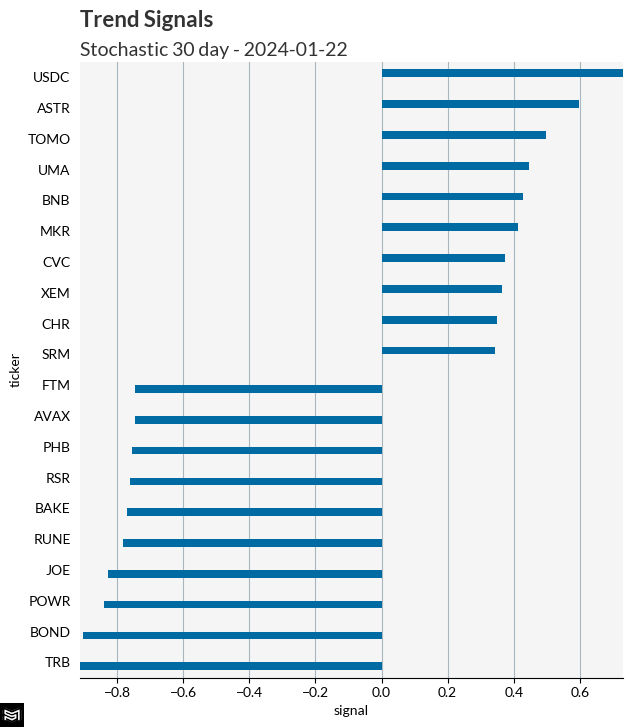

In [178]:
plot_bar(pd.concat([trend_signals_bar[:10], trend_signals_bar[-10:]], axis=1), 
         title="Trend Signals",
         subtitle=f"Stochastic 30 day - {trend_df.iloc[-1].name[0].date()}",
         axis='horizontal', 
         y_label='ticker', 
         x_label='signal', 
         add_logo=True,
        )